# Description

This is the neural network training and testing pipeline.

There are two different models I developed and this is the pre-final one.

The structure of the model is tree-like and consists of a common starter block and two separate branches for classification and regression respectively.

The starter block is convolutional. The classification branch consists of 3 convolutional and 2 linear (dense) blocks. The regression branch consists of 2 convolutional and 2 linear (dense) blocks. Each convolutional block consists of 3 layers: convolution, activation and pooling. Each linear block consists of 2 layers: linear and activation. Between the last convolutional and the first linear block in each branch there is a dropout layer. The outputs of the branches are concatenated in a single tensor at final.
The detailed circuit is below.

## Result metrics

mIoU 64%, classification accuracy 80%, 0.77ms, 13535 train, 271 valid, 407 test

# Imports and environment

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import datetime
import pickle
import os
from copy import deepcopy

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from IPython.display import display as disp
from IPython.display import clear_output

# Loading the dataset

The preprocessing class code is here for compatibility with pickle that loads an instance of this class (the dataset).

It is the same as in the preprocessing pipeline and it is no sense to skim it again.

In [2]:
class image_objects():
    """
    Image loading and preprocessing.
    """
    
    def __init__(self, path, filenames,):
        """
        Initialization.
        Loads the metadata from a local disk.
        path : files directory
        filenames : array of the arrays of the two items (jpg and txt) for each image
        """
        self.path = path
        self.filenames = filenames
        self.augmentation_is_done = False
        
        self.meta_raw = []
        for i in np.arange(self.filenames.shape[0]):
            with open(f'{self.path}{self.filenames[i, 1]}', 'r') as f:
                string = f.read()
            self.meta_raw.append(np.array(string.split(' '), dtype='int'))
        
        self.meta_raw = np.array(self.meta_raw)
    
    
    def split_indices(self, valid_frac, test_frac,):
        """
        Splits the indices to the train, validation and test samples.
        """
        index = np.arange(self.meta_raw.shape[0])
        labels = self.meta_raw[:, 0].copy()
        classes = np.unique(self.meta_raw[:, 0])

        index_by_class = []

        for i in np.arange(classes.shape[0]):
            index_by_class.append(index[labels == classes[i]])
            np.random.shuffle(index_by_class[i])

            bounds = np.array(
                [
                    index_by_class[i].shape[0] * (1 - (valid_frac + test_frac)),
                    index_by_class[i].shape[0] * (1 - test_frac),
                ],
                dtype = 'int'
            )

            index_by_class[i] = [
                index_by_class[i][:bounds[0]],
                index_by_class[i][bounds[0]:bounds[1]],
                index_by_class[i][bounds[1]:],
            ]

        self.index_tr_basic = np.array([], dtype='int')
        self.index_va = np.array([], dtype='int')
        self.index_te = np.array([], dtype='int')

        for i in np.arange(classes.shape[0]):
            self.index_tr_basic = np.append(self.index_tr_basic, index_by_class[i][0])
            self.index_va = np.append(self.index_va, index_by_class[i][1])
            self.index_te = np.append(self.index_te, index_by_class[i][2])

        np.random.shuffle(self.index_tr_basic)
        np.random.shuffle(self.index_va)
        np.random.shuffle(self.index_te)

        print(self.index_tr_basic.shape)
        print(self.index_va.shape)
        print(self.index_te.shape)


    def transform(self, size=256, subtract_mean=False,):
        """
        Transforms the images from raw to input-ready format.
        size : size of the final square image
        """
        self.size = size
        self.meta_bw = self.meta_raw.copy()
        self.meta_padded = self.meta_raw.copy()
        self.meta_resized = self.meta_padded.copy()
        self.pads = np.zeros((self.filenames.shape[0], 4), dtype='int')
        self.size_raw = []
        self.imgs = []
        
        for i in np.arange(self.filenames.shape[0]):
            img = np.array(Image.open(f'{self.path}{self.filenames[i, 0]}'))
            if img.ndim == 2:
                img = np.expand_dims(img, 2)
            self.size_raw.append(img.shape[:2])
        
            # Black and white
            img = np.mean(img, axis=2, dtype='int')
            
            # Padding
            self.pads[i, 0] = (np.max(img.shape[:2]) - img.shape[0]) // 2                     # top
            self.pads[i, 1] = (np.max(img.shape[:2]) - img.shape[0]) // 2 + img.shape[0] % 2  # bottom
            self.pads[i, 2] = (np.max(img.shape[:2]) - img.shape[1]) // 2                     # left
            self.pads[i, 3] = (np.max(img.shape[:2]) - img.shape[1]) // 2 + img.shape[1] % 2  # right
            
            img = cv2.copyMakeBorder(img, *self.pads[i], cv2.BORDER_REPLICATE)
            self.meta_padded[i, 1] += self.pads[i, 2]
            self.meta_padded[i, 2] += self.pads[i, 0]
            self.meta_padded[i, 3] += self.pads[i, 3]
            self.meta_padded[i, 4] += self.pads[i, 1]
            
            # Resizing
            img = cv2.resize(img.astype('float64'), (self.size, self.size), interpolation=cv2.INTER_CUBIC)
            self.meta_resized[i] = self.meta_padded[i]
            self.meta_resized[i, 1:5] = np.round(self.meta_resized[i, 1:5] * (self.size / np.max(self.size_raw[i])), 0).astype('int')
            
            # Adding an image to the list
            self.imgs.append(np.array(img, dtype='uint8'))
        
        # Forming the array of images
        self.imgs = np.array(self.imgs, dtype='uint8')
        
        # Subtracting the mean
        if subtract_mean:
            mean = np.round(np.mean(self.imgs[self.index_tr_basic]), 0).astype('uint8')
            self.imgs -= mean

        self.size_raw = np.array(self.size_raw)
        
        self.print_imgs_array_details()
    
    
    def show(self, i=None, mode='resized', roi=True,):
        """
        Displays the image.
        mode : "raw", "bw", "padded", "resized"
        roi : bool
        """
        # Choosing the item
        i = i if i != None else np.random.randint(0, self.filenames.shape[0])
        print(i)

        # Loading the raw image if necessary
        if mode != 'mask':
            img_raw = np.array(Image.open(f'{self.path}{self.filenames[i, 0]}'))
        
        # Computing the image
        if mode == 'raw':
            img = img_raw
            ax_img = plt.imshow(img)
            meta = self.meta_raw[i]
        elif mode == 'bw':
            img = np.mean(img_raw, axis=2, dtype='int')
            ax_img = plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            meta = self.meta_bw[i]
        elif mode == 'padded':
            img = cv2.copyMakeBorder(np.mean(img_raw, axis=2, dtype='int'), *self.pads[i], cv2.BORDER_REPLICATE)
            ax_img = plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            meta = self.meta_padded[i]
        if mode == 'resized':
            img = cv2.resize(
                cv2.copyMakeBorder(np.mean(img_raw, axis=2, dtype='int'), *self.pads[i], cv2.BORDER_REPLICATE).astype('float64'), 
                (self.size, self.size),
                interpolation=cv2.INTER_CUBIC
            )
            ax_img = plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            try:
                meta = self.meta_resized[i]
            except:
                meta = self.meta_augment[i]
        if mode == 'mask':
            img = self.imgs[i, 1]
            ax_img = plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            try:
                meta = self.meta_resized[i]
            except:
                meta = self.meta_augment[i]
        
        # Plotting the image
        disp(meta)
        ax = []
        ax.append(ax_img)
        if roi:
            ax.append(plt.vlines((meta[1], meta[3],), meta[2], meta[4], colors='red'))
            ax.append(plt.hlines((meta[2], meta[4],), meta[1], meta[3], colors='red'))
        plt.show(ax)
    
    
    def augmentation(self,):
        """
        Implementation of the augmentation.
        """
        if self.augmentation_is_done is not True:
            self.imgs = np.append(self.imgs, np.flip(self.imgs[self.index_tr_basic], axis=2), axis=0)
            self.imgs = np.append(self.imgs, np.transpose(self.imgs[self.index_tr_basic], axes=(0, 2, 1)), axis=0)
            self.imgs = np.append(self.imgs, np.flip(np.transpose(self.imgs[self.index_tr_basic], axes=(0, 2, 1)), axis=2), axis=0)
            self.imgs = np.append(self.imgs, np.flip(self.imgs[self.index_tr_basic], axis=1), axis=0)

            meta_1 = self.meta_resized[self.index_tr_basic].copy()
            meta_2 = self.meta_resized[self.index_tr_basic].copy()
            meta_3 = self.meta_resized[self.index_tr_basic].copy()
            meta_4 = self.meta_resized[self.index_tr_basic].copy()

            meta_1[:, 1] = self.size - self.meta_resized[self.index_tr_basic][:, 3]
            meta_1[:, 3] = self.size - self.meta_resized[self.index_tr_basic][:, 1]

            meta_2[:, 1] = meta_1[:, 2]
            meta_2[:, 2] = self.size - meta_1[:, 3]
            meta_2[:, 3] = meta_1[:, 4]
            meta_2[:, 4] = self.size - meta_1[:, 1]

            meta_3[:, 1] = self.size - meta_2[:, 3]
            meta_3[:, 2] = meta_2[:, 2]
            meta_3[:, 3] = self.size - meta_2[:, 1]
            meta_3[:, 4] = meta_2[:, 4]

            meta_4[:, 2] = self.size - self.meta_resized[self.index_tr_basic][:, 4]
            meta_4[:, 4] = self.size - self.meta_resized[self.index_tr_basic][:, 2]

            self.meta_augment = self.meta_resized.copy()
            self.meta_augment = np.append(self.meta_augment, meta_1, axis=0)
            self.meta_augment = np.append(self.meta_augment, meta_2, axis=0)
            self.meta_augment = np.append(self.meta_augment, meta_3, axis=0)
            self.meta_augment = np.append(self.meta_augment, meta_4, axis=0)
        
        self.index_tr = self.index_tr_basic.copy()
        self.index_tr = np.append(self.index_tr, np.arange(self.filenames.shape[0], self.imgs.shape[0]))
        
        self.meta_ready = self.meta_augment.copy().astype('float64')
        self.meta_ready[:, 0][self.meta_ready[:, 0] == 2] = 0
        self.meta_ready[:, 1:] = self.meta_ready[:, 1:] * 1. / self.size
        
        self.augmentation_is_done = True
        self.print_imgs_array_details()
        

    def print_imgs_array_details(self,):
        """
        Displays imgs array shape, memory usage and dtype.
        """
        print(self.imgs.shape)
        print(images.imgs.nbytes // 1024**2, 'Mb')
        print(self.imgs.dtype)
    
    
    def unsqueeze_imgs(self,):
        """
        Inserts additional dimention in the second position (dim 1).
        
        For example:
        Shape: (1000, 192, 192) ---> (1000, 1, 192, 192)
        """
        self.imgs = self.imgs.reshape(self.imgs.shape[0], 1, self.imgs.shape[1], self.imgs.shape[2])
        self.print_imgs_array_details()
    
    
    def create_roi_masks(self,):
        """
        Creates the binary layer where pixels of ROI are ones and others are zeros.
        USING THIS FOR TRAINING IS A LEAK!!!
        """
        self.imgs = self.imgs.reshape(self.imgs.shape[0], 1, self.imgs.shape[1], self.imgs.shape[2])
        self.imgs = np.concatenate((self.imgs, np.full(self.imgs.shape, 255, dtype='uint8')), axis=1)
        
        for i in np.arange(self.imgs.shape[0]):
            self.imgs[
                i,
                1,
                self.meta_augment[i, 2] : self.meta_augment[i, 4],
                self.meta_augment[i, 1] : self.meta_augment[i, 3],
            ] = 0
        
        self.print_imgs_array_details()
    
    
    def augmentation_show(self, i=None, mask=False,):
        """
        Displays the set of images after augmentation.
        """
        i = i if i != None else np.random.randint(0, self.index_tr_basic.shape[0])
        print(i)
        print(self.index_tr_basic[i])
        
        AUGS = 5
        fig, ax = plt.subplots(1, AUGS, figsize=(20, 5))
        
        for aug in np.arange(AUGS):
            if aug == 0:
                j = self.index_tr_basic[i]
            else:
                j = self.filenames.shape[0] + i + (aug - 1) * self.index_tr_basic.shape[0]
            disp(self.meta_augment[j])
            if self.imgs.ndim == 3:
                ax[aug].imshow(self.imgs[j], cmap='gray',)
            elif self.imgs.ndim == 4:
                layer = 1 if mask else 0
                ax[aug].imshow(self.imgs[j, layer], cmap='gray',)
            ax[aug].vlines((self.meta_augment[j, 1], self.meta_augment[j, 3],), self.meta_augment[j, 2], self.meta_augment[j, 4], colors='red')
            ax[aug].hlines((self.meta_augment[j, 2], self.meta_augment[j, 4],), self.meta_augment[j, 1], self.meta_augment[j, 3], colors='red')

        plt.show(fig)

## Loading with pickle

In [3]:
with open('./data/images256.pkl', 'rb') as f:
    images = pickle.load(f)

# Modelling

## Classes and functions

In [4]:
def filters_3x3(ndim=2,):
    """
    Defining the filters of 3x3 size based on the Sobel-Feldman operator
    and simple +1/-1 filters of 3x3 size.
    """
    # Basic Sobel filter
    sobel_base = np.array(
        [
            [-1, -2, -1,],
            [0, 0, 0,],
            [1, 2, 1,],
        ]
    )
    
    # Basic ones filter
    ones_base = np.ones((3, 3))
    ones_base[2:] = -ones_base[2:]
    
    # Variations of filter forms
    filters = np.array(
        [
            sobel_base,
            sobel_base.T,
            ones_base,
            ones_base.T,
            np.flip(ones_base),
            np.flip(ones_base.T),
        ]
    )
    
    # Formatting the array (necessary shape: (6, ndim, 3, 3))
    filters = filters.reshape(filters.shape[0], 1, filters.shape[1], filters.shape[2],)
    for _ in np.arange(ndim-1):
        filters = np.concatenate((filters, filters,), axis=1)
    
    return filters

Eventually, these filters are not applied for initialization of the weights. I saved this code to show the approach once I considered.

### Net

The pre-final version of the neural network class.

In [5]:
class Net(nn.Module):
    """
    Neural network structure.
    """
    
    def __init__(self, out_units_final,):
        """
        Layers initialization.
        """
        super(Net, self,).__init__()
        
        # Common branch
        self.common_conv = nn.ModuleList(
            modules = [
                nn.Conv2d(1, 12, 3, padding=1, stride=1, bias=False),
                nn.ReLU(),
                nn.MaxPool2d(4, padding=0, stride=4),
            ]
        )

        # Classification branch
        self.classif_conv = nn.ModuleList(
            modules = [
                nn.Conv2d(12, 10, 3, padding=1, stride=1, bias=False),
                nn.ReLU(),
                nn.MaxPool2d(4, padding=1, stride=4),
                nn.Conv2d(10, 12, 3, padding=1, stride=2, bias=False),
                nn.ReLU(),
                nn.AvgPool2d(2, padding=0, stride=2),
                nn.Conv2d(12, 12, 3, padding=1, stride=2, bias=False),
                nn.Sigmoid(),
                nn.AvgPool2d(2, padding=0, stride=2),
                nn.Dropout2d(p=0.5),
            ]
        )

        self.classif_lin = nn.ModuleList(
            modules = [
                nn.Linear(12, 8),
                nn.Sigmoid(),
                nn.Linear(8, 1),
                nn.Sigmoid(),
            ]
        )
        
        # Regression branch
        self.regress_conv = nn.ModuleList(
            modules = [
                nn.Conv2d(12, 10, 3, padding=1, stride=1, bias=False),
                nn.ReLU(),
                nn.MaxPool2d(4, padding=1, stride=4),
                nn.Conv2d(10, 10, 3, padding=1, stride=2, bias=False),
                nn.ReLU(),
                nn.MaxPool2d(8, padding=0, stride=8),
                nn.Dropout2d(p=0.5),
            ]
        )
        
        self.regress_lin = nn.ModuleList(
            modules = [
                nn.Linear(10, 8),
                nn.Sigmoid(),
                nn.Linear(8, out_units_final-1),
                nn.Sigmoid(),
            ]
        )
        
        
    def forward(self, x):
        """
        Forward run.
        """
        # Common branch
        for i in np.arange(len(self.common_conv)):
            x = self.common_conv[i](x)
        
        # Classification branch
        x_c = x
        for i in np.arange(len(self.classif_conv)):
            x_c = self.classif_conv[i](x_c)
        
        x_c = x_c.squeeze(2).squeeze(2)
        for i in np.arange(len(self.classif_lin)):
            x_c = self.classif_lin[i](x_c)
        
        # Regression branch
        x_r = x
        for i in np.arange(len(self.regress_conv)):
            x_r = self.regress_conv[i](x_r)
        
        x_r = x_r.squeeze(2).squeeze(2)
        for i in np.arange(len(self.regress_lin)):
            x_r = self.regress_lin[i](x_r)
        
        # Concatenation
        x = torch.cat((x_c, x_r), dim=1)
        
        return x

### Trainer

The pre-final version of the learning implementation class.

In [6]:
class Trainer():
    """
    Implementation of the neural network training process.
    """

    def __init__(
        self,
        model,
        criterion,
        cuda_number = torch.cuda.current_device(),
    ):
        self.cuda_number = cuda_number
        self.model = model.float().cuda(self.cuda_number)
        self.criterion = criterion
    
    
    def epoch_func(self, epoch, mode, loader, y,):
        '''
        Implementation of the training and the validation during one epoch.
        '''
        # Time of the beginning
        time_begin = datetime.datetime.now()
        
        # Model mode: train or eval ('eval' is the mode for prediction)
        if mode == 'train':
            self.model.train()
        elif ((mode == 'valid') | (mode == 'test')):
            self.model.eval()
        
        # Initializing global vars
        y_pred = torch.cuda.FloatTensor([])
        epoch_loss = 0
        epoch_loss_mciou = 0
        epoch_loss_bce = 0
        batches = 0
        PIXEL_VALUES_RANGE = 255
        
        # Batch loop
        for batch in loader:
            X_batch = batch[0].cuda(self.cuda_number) * 1. / PIXEL_VALUES_RANGE
            y_batch = batch[1].cuda(self.cuda_number)
        
            # Computing
            y_pred_batch = self.model(X_batch)
            batch_loss, batch_loss_bce, batch_loss_mciou = self.criterion(y_pred_batch, y_batch)
            
            if mode == 'train':
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
            elif ((mode == 'valid') | (mode == 'test')):
                batch_loss.backward()
        
            # Collecting batch results
            epoch_loss += batch_loss.item()
            epoch_loss_bce += batch_loss_bce.item()
            epoch_loss_mciou += batch_loss_mciou.item()
            batches += 1
            y_pred = torch.cat((y_pred, y_pred_batch))
        
        # Loss and metrics
        epoch_loss /= batches
        epoch_loss_bce /= batches
        epoch_loss_mciou /= batches
        
        accuracy = torch_accuracy_score(
            y_pred[:, 0],
            y[:, 0],
            cuda_number=self.cuda_number
        )
        
        iou_metric = torch_iou(y_pred[:, 1:], y[:, 1:])
        miou = iou_metric.mean_iou_score()

        if mode == 'train':
            self.epoch_loss_tr = epoch_loss
            self.epoch_loss_bce_tr = epoch_loss_bce
            self.epoch_loss_mciou_tr = epoch_loss_mciou
            self.accuracy_tr = accuracy
            self.miou_tr = miou
            self.walltime_tr = (datetime.datetime.now() - time_begin).total_seconds()
        elif mode == 'valid':
            self.epoch_loss_va = epoch_loss
            self.epoch_loss_bce_va = epoch_loss_bce
            self.epoch_loss_mciou_va = epoch_loss_mciou
            self.accuracy_va = accuracy
            self.miou_va = miou
            self.walltime_va = (datetime.datetime.now() - time_begin).total_seconds()
        elif mode == 'test':
            epoch_loss_te = epoch_loss
            accuracy_te = accuracy
            miou_te = miou
            walltime_te = (datetime.datetime.now() - time_begin) / datetime.timedelta(microseconds=1)
        
        # Saving state dicts
        if mode == 'valid':
            self.state_dicts.append(
                [
                    deepcopy(self.model.state_dict()),
                    deepcopy(self.optimizer.state_dict()),
                    {
                        'epoch': epoch,
                        'loss_tr': self.epoch_loss_tr,
                        'loss_va': self.epoch_loss_va,
                        'acc_tr': self.accuracy_tr,
                        'acc_va': self.accuracy_va,
                        'loss_bce_tr': self.epoch_loss_bce_tr,
                        'loss_bce_va': self.epoch_loss_bce_va,
                        'loss_mciou_tr': self.epoch_loss_mciou_tr,
                        'loss_mciou_va': self.epoch_loss_mciou_va,
                        'miou_tr': self.miou_tr,
                        'miou_va': self.miou_va,
                    },
                ]
            )
        
        # Verbosing
        if mode == 'valid':
            walltime = self.walltime_tr + self.walltime_va
            verbose_string = ('[{:03d}] wall: {:3d}:{:02d},  loss: {:.3f} / {:.3f},  acc.: {:.3f} / {:.3f},  bce_loss: {:.3f} / {:.3f},  mciou_loss: {:.3f} / {:.3f},  miou: {:.3f} / {:.3f}  [{:03d}]'
                  .format(
                      epoch,
                      int(walltime // 60),
                      int(walltime % 60),
                      self.epoch_loss_tr,
                      self.epoch_loss_va,
                      self.accuracy_tr,
                      self.accuracy_va,
                      self.epoch_loss_bce_tr,
                      self.epoch_loss_bce_va,
                      self.epoch_loss_mciou_tr,
                      self.epoch_loss_mciou_va,
                      self.miou_tr,
                      self.miou_va,
                      epoch,
                  )
                 )
            self.verbose_strings.append(verbose_string)
            if epoch % self.graph_refreshing_interval == 0:
                clear_output(wait=True)
                print(f'The training graph is refreshed every {self.graph_refreshing_interval} epochs.')
                self.training_graph()
                for i in np.arange(len(self.verbose_strings)):
                    print(self.verbose_strings[i])
            else:
                print(verbose_string)
        elif mode == 'test':
            walltime = np.round((walltime_te / 1e6), 3)  # seconds
            inference_time = np.round(((walltime_te / y.shape[0]) / 1e3), 3)  # milliseconds
            print('[test] wall: {:.3f}s,  inference: {:.3f}ms,  loss: {:.3f},  acc.: {:.3f},  miou: {:.3f}  [test]'
                  .format(
                      walltime,
                      inference_time,
                      epoch_loss_te,
                      accuracy_te,
                      miou_te,
                  )
                 )
        

    def training_graph(self,):
        """
        Plots the training graph.
        """
        # Data array init
        training_results = np.empty((len(self.state_dicts), len(self.state_dicts[0][2])), dtype='float64')
        
        # Collecting the data
        for i in np.arange(len(self.state_dicts)):
            for j, key in enumerate(self.state_dicts[i][2].keys()):
                training_results[i, j] = self.state_dicts[i][2][key]
        legend = []
        for key in self.state_dicts[0][2].keys():
            legend.append(key)
        
        # Plotting
        plt.figure(figsize=(20, 8))
        plt.subplot(121)
        plt.plot(training_results[:, 0], training_results[:, 5:9])
        plt.plot(training_results[:, 0], training_results[:, 1:3])
        plt.legend((*legend[5:9], *legend[1:3],))
        plt.xlim((0, (training_results[-1, 0] // 100 + 1) * 100))
        plt.ylim(top=1.)
        plt.subplot(122)
        plt.plot(training_results[:, 0], training_results[:, 3:5])
        plt.plot(training_results[:, 0], training_results[:, 9:11])
        plt.legend((*legend[3:5], *legend[9:11],))
        plt.xlim((0, (training_results[-1, 0] // 100 + 1) * 100))
        plt.show()

    
    def fit(
        self,
        X_tr,
        X_va,
        y_tr,
        y_va,
        batch_size,
        learning_rate,
        optimizer_weight_decay = 0,
        optim_scheduler_step_size = 50,
        optim_scheduler_gamma = 0.9,
        epochs = 1000,
        early_stopping_serie_length = 5,
        graph_refreshing_interval = 10,
    ):
        '''
        Implementation of the model training.
        '''
        # Output vars init
        self.state_dicts = []
        self.verbose_strings = []
        self.graph_refreshing_interval = graph_refreshing_interval
        
        # Early stopping, walltime init
        self.last_epoch_losses_va = torch.full((early_stopping_serie_length + 1,), 1e10, dtype=torch.float,)
        self.last_epoch_loss_ratios = torch.full((early_stopping_serie_length + 1,), 1., dtype=torch.float,)
        time_begin = datetime.datetime.now()
        
        # Optimizer init
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr = learning_rate,
            weight_decay = optimizer_weight_decay,
        )
        optim_scheduler = optim.lr_scheduler.StepLR(
            self.optimizer,
            step_size = optim_scheduler_step_size,
            gamma = optim_scheduler_gamma,
        )
        
        # Tensors
        X_tr = torch.cuda.FloatTensor(X_tr)
        X_va = torch.cuda.FloatTensor(X_va)
        y_tr = torch.cuda.FloatTensor(y_tr)
        y_va = torch.cuda.FloatTensor(y_va)

        # Datasets
        dataset_tr = TensorDataset(X_tr, y_tr)
        dataset_va = TensorDataset(X_va, y_va)
        
        # Loaders
        loader_tr = DataLoader(dataset_tr, batch_size=batch_size,)
        loader_va = DataLoader(dataset_va, batch_size=batch_size,)
        
        # Valid baseline accuracy
        baseline_accuracy = y_va[y_va[:, 0] == 0].shape[0] / y_va.shape[0]
        print('baseline valid accuracy: {:.5f}\n'.format(baseline_accuracy))
        
        # Training loop
        for epoch in np.arange(epochs):
            self.epoch_func(epoch, 'train', loader_tr, y_tr,)
            self.epoch_func(epoch, 'valid', loader_va, y_va,)
            optim_scheduler.step()
            if self.early_stopping(epoch):
                break
        
        # Total walltime
        walltime = (datetime.datetime.now() - time_begin).total_seconds()
        print('========= Training is finished! =========\nwall total: {:3d}:{:02d}'.format(int(walltime // 60), int(walltime % 60),))
    
    
    def load_state_dicts(
        self,
        number,
        path = './data/models/',
    ):
        """
        Loads state dicts.
        """
        # Init
        path = path if path[-1] != '/' else path[:-1]
        number = '{:03d}'.format(number)
        
        # Loading
        try:
            self.model_state_dict_loaded = torch.load(f'{path}/{number}/{number}_MODEL.pt')
        except:
            self.model_state_dict_loaded = None
            print('No MODEL')
        
        try:
            self.optim_state_dict_loaded = torch.load(f'{path}/{number}/{number}_OPTIM.pt')
        except:
            self.optim_state_dict_loaded = None
            print('No OPTIM')
        
        try:
            with open(f'{path}/{number}/{number}_MTRCS.pkl', 'rb') as f:
                self.metrics_state_dict_loaded = pickle.load(f)
        except:
            self.metrics_state_dict_loaded = {}
            print('No MTRCS')
        
        try:
            with open(f'{path}/{number}/{number}_DICTS.pkl', 'rb') as f:
                self.state_dicts_loaded = pickle.load(f)
        except:
            print('No list of dicts')
    
    
    def assign_state_dicts(
        self,
        epoch_from_last_training = None,
        epoch_from_loaded_list = None,
    ):
        """
        Assigns state dicts to the model and the optimizer.
        """
        # Init
        model_dict = None
        optim_dict = None
        metrics = None
        fail_message = 'failed'
        
        # Defining state dicts for assignment
        if epoch_from_last_training != None:
            try:
                model_dict = self.state_dicts[epoch_from_last_training][0]
                optim_dict = self.state_dicts[epoch_from_last_training][1]
                metrics = self.state_dicts[epoch_from_last_training][2]
            except:
                print(fail_message)
        elif epoch_from_loaded_list != None:
            try:
                model_dict = self.state_dicts_loaded[epoch_from_loaded_list][0]
                optim_dict = self.state_dicts_loaded[epoch_from_loaded_list][1]
                metrics = self.state_dicts_loaded[epoch_from_loaded_list][2]
            except:
                print(fail_message)
        else:
            try:
                model_dict = self.model_state_dict_loaded
                optim_dict = self.optim_state_dict_loaded
                metrics = self.metrics_state_dict_loaded
            except:
                print(fail_message)
        
        # Assigning
        self.model.load_state_dict(model_dict)
        self.model.eval()
        
        try:
            self.optimizer.load_state_dict(optim_dict)
        except:
            print('Optimizer is not initialized\n')
        
        print(metrics)
    
    
    def find_best_epoch(
        self,
        state_dicts_list = None,
        win=10,
    ):
        """
        Recognizing the epoch with the lowest loss values.
        
        The algorithm consists of two steps:
        1. recognizing the best group of epochs (rolling window);
        2. recognizing he best epoch in the best group.
        
        Definition of the lowest loss: min(train_loss^2 + valid_loss^2)
        """
        # Init
        if state_dicts_list == None:
            state_dicts_list = self.state_dicts
        
        # Loss arrays
        losses = np.zeros((len(state_dicts_list), 2), dtype='float64')
        for i in np.arange(losses.shape[0]):
            losses[i, 0] = state_dicts_list[i][2]['loss_tr']
            losses[i, 1] = state_dicts_list[i][2]['loss_va']
        
        # Loss rolling mean arrays
        win = win if losses.shape[0] > win else 1
        losses_rolling_mean = np.zeros(((losses.shape[0] - win + 1), 2), dtype='float64')
        for i in np.arange(losses_rolling_mean.shape[0]):
            losses_rolling_mean[i] = np.mean(losses[i : (i + win)], axis=0)
        
        # Best epoch in two steps
        best_win = np.argmin(np.sum(np.square(losses_rolling_mean), axis=1))
        best_epoch_number = best_win + np.argmin(np.sum(np.square(losses[best_win : (best_win + win)]), axis=1))
        
        return best_epoch_number
    
    
    def save_state_dicts(
        self,
        number,
        name = 'test',
        path = './data/models/',
        only_best_epoch = False,
        particular_epoch_number = None,
        rolling_window = 10
    ):
        """
        Saves state dicts of the model and the optimizer.
        """
        # Init
        path = path if path[-1] != '/' else path[:-1]
        epoch_number_to_save = -1
        number = '{:03d}'.format(number)
        
        # Defining the epoch number to save
        if particular_epoch_number != None:
            epoch_number_to_save = particular_epoch_number
        elif only_best_epoch:
            try:
                epoch_number_to_save = self.find_best_epoch(self.state_dicts, win=rolling_window)
            except:
                print('No state dicts')
        else:
            None
        
        # Saving on a disk
        try:
            os.mkdir(f'{path}/{number}')
        except:
            None
        
        if not os.path.exists(f'{path}/{number}/{number}_{name}.txt'):
            with open(f'{path}/{number}/{number}_{name}.txt', 'w') as f:
                f.write(str(name))
        if epoch_number_to_save > -1:
            # The particular epoch number
            if not (
                os.path.exists(f'{path}/{number}/{number}_MODEL.pt')
                | os.path.exists(f'{path}/{number}/{number}_OPTIM.pt')
                | os.path.exists(f'{path}/{number}/{number}_MTRCS.txt')
                | os.path.exists(f'{path}/{number}/{number}_MTRCS.pkl')
            ):
                torch.save(self.state_dicts[epoch_number_to_save][0], f'{path}/{number}/{number}_MODEL.pt')
                torch.save(self.state_dicts[epoch_number_to_save][1], f'{path}/{number}/{number}_OPTIM.pt')
                with open(f'{path}/{number}/{number}_MTRCS.txt', 'w') as f:
                    f.write(str(self.state_dicts[epoch_number_to_save][2]))
                with open(f'{path}/{number}/{number}_MTRCS.pkl', 'wb') as f:
                    pickle.dump(self.state_dicts[epoch_number_to_save][2], f)
            else:
                print('The files already exist')
        else:
            # The entire list of the state dicts
            if not os.path.exists(f'{path}/{number}/{number}_DICTS.pkl'):
                with open(f'{path}/{number}/{number}_DICTS.pkl', 'wb') as f:
                    pickle.dump(self.state_dicts, f)
            else:
                print('The file already exists')
    
    
    def predict(
        self,
        X_te,
        y_te,
        batch_size,
    ):
        """
        Implementation of prediction with the trained model.
        """
        # Tensors
        X_te = torch.cuda.FloatTensor(X_te)
        y_te = torch.cuda.FloatTensor(y_te)

        # Dataset
        dataset_te = TensorDataset(X_te, y_te)
        
        # Loader
        loader_te = DataLoader(dataset_te, batch_size=batch_size,)
        
        # Single epoch
        self.epoch_func(0, 'test', loader_te, y_te,)
    
    
    def early_stopping(self, epoch,):
        """
        Implementation of the early stopping of the training process.
        If loss increases during the serie of iterations of "serie_length",
        the process halts.
        """
        self.last_epoch_losses_va = torch.roll(self.last_epoch_losses_va, -1, 0)
        self.last_epoch_losses_va[-1] = self.epoch_loss_va
        diff = torch.tensor([(self.last_epoch_losses_va[i+1] - self.last_epoch_losses_va[i]) for i in np.arange(self.last_epoch_losses_va.shape[0] - 1)])
        
        self.last_epoch_loss_ratios = torch.roll(self.last_epoch_loss_ratios, -1, 0)
        self.last_epoch_loss_ratios[-1] = self.epoch_loss_va / self.epoch_loss_tr
        ratio_treshold = 1.50 if epoch < 50 else 1.15
        
        if (
            (
                (torch.all(diff > 0)) 
                & (self.epoch_loss_va > self.epoch_loss_tr)
            ) 
            | (torch.all(self.last_epoch_loss_ratios > ratio_treshold))
        ):
            return True
        else:
            return False

### Metrics and losses

You can see the detailed desctiptions of these functions in \#002 notebook.

In [7]:
def torch_accuracy_score(y_pred, y_true, threshold=0.5, cuda_number=0,):
    """
    Accuracy score based on the PyTorch framework.
    """
    y_pred_class = torch.zeros(size=(y_pred.shape[0], 1), dtype=torch.uint8).squeeze(1).cuda(cuda_number)
    y_pred_class[y_pred > threshold] = 1
    accuracy = torch.eq(y_true.byte(), y_pred_class).sum().item() / y_true.shape[0]
    return accuracy

In [8]:
class torch_iou():
    """
    Metric and loss function based on the intersection-of-union (IoU) principle.
    """
    
    def __init__(self, y_pred, y_true,):
        """
        Initialization and pre-computation.
        
        Column order of the input tensors:
        xmin ymin xmax ymax
        """
        # Init
        self.xmin_pred = y_pred[:, 0]
        self.ymin_pred = y_pred[:, 1]
        self.xmax_pred = y_pred[:, 2]
        self.ymax_pred = y_pred[:, 3]
        self.xmin_true = y_true[:, 0]
        self.ymin_true = y_true[:, 1]
        self.xmax_true = y_true[:, 2]
        self.ymax_true = y_true[:, 3]
        
        self.w_true = self.xmax_true - self.xmin_true
        self.h_true = self.ymax_true - self.ymin_true
        self.w_pred = self.xmax_pred - self.xmin_pred
        self.h_pred = self.ymax_pred - self.ymin_pred
        
        a_true = self.w_true * self.h_true
        a_pred = self.w_pred * self.h_pred
        
        self.eps = 1e-10
        
        # Area of overlap (aoo)
        aoo = (
            (torch.minimum(self.xmax_true, self.xmax_pred) - torch.maximum(self.xmin_true, self.xmin_pred))
            * (torch.minimum(self.ymax_true, self.ymax_pred) - torch.maximum(self.ymin_true, self.ymin_pred))
        )
        
        # Area of overlap limitation
        aoo_limit = torch.minimum(a_true, a_pred)
        aoo[aoo > aoo_limit] = aoo_limit[aoo > aoo_limit]
        
        # Area of union (aou)
        aou = a_true + a_pred - aoo

        # Intersection of union
        self.iou = torch.clamp(
            aoo / (aou + self.eps),
            0.,
            100.
        )
    
    
    def mean_iou_score(self,):
        """
        Mean IoU score function.
        Returns scalar, not tensor.
        """
        miou = torch.mean(self.iou, dim=0).item()
        return miou
    
    
    def mean_ciou_loss(self,):
        """
        Mean Complete IoU.
        The idea had been got from the article on "arXiv.org".
        
        Formula:
        
        ciou_loss = 1 - iou + diou_term + aspratio_term = 
        = 1 - iou + (centre_distance / enclosing_box_diag)^2 +
        + v^2 / ((1 - iou) + v)
        
        "diou_term" - distance IoU term
        "aspratio_term" - aspect ratio term
        
        Computation of these terms is implemented in the final step
        to avoid an exceed operation of assignment. This is crucial while
        using GPU.
        """
        # distance IoU term
        centre_distance = torch.hypot(
            ((self.xmin_pred + self.xmax_pred) / 2) - ((self.xmin_true + self.xmax_true) / 2),
            ((self.ymin_pred + self.ymax_pred) / 2) - ((self.ymin_true + self.ymax_true) / 2),
        )
        
        enclosing_box_diag = torch.sqrt(
            torch.square(
                torch.maximum(self.xmax_true, self.xmax_pred) - torch.minimum(self.xmin_true, self.xmin_pred)
            )
            + torch.square(
                torch.maximum(self.ymax_true, self.ymax_pred) - torch.minimum(self.ymin_true, self.ymin_pred)
            )
        )
        
        # aspect ratio term
        # 4/(pi^2) ~ 0.40528
        v = 0.40528 * torch.square(
            (
                torch.arctan(self.w_true / (self.h_true + self.eps))
                - torch.arctan(self.w_pred / (self.h_pred + self.eps))
            )
        )
        
        # mean ciou loss
        ciou = (
            1.0
            - self.iou 
            + torch.clamp(  # diou_term
                torch.square(centre_distance / (enclosing_box_diag + self.eps)),
                -100.,
                100.,
            )
            + torch.clamp(  # aspratio_term
                torch.square(v) / ((1 - self.iou) + v + self.eps),
                -100.,
                100.,
            )
        )
        
        return torch.mean(ciou, dim=0)

In [9]:
class BCE_MCIOU_Loss(nn.Module):
    """
    Custom loss function.
    """
    
    def __init__(self, class_weights=(1.0, 1.0)):
        """
        Initialization.
        """
        super(BCE_MCIOU_Loss, self,).__init__()
        self.class_weights = torch.cuda.FloatTensor(class_weights)
        
        
    def forward(self, y_pred, y_true,):
        """
        Computing the loss.
        """
        # Class weights
        # weights = torch.full_like(y_true[:, 0], 0.5, dtype=torch.float)
        # weights[y_true[:, 0] == 0] = class_weights[0]
        # weights[y_true[:, 0] == 1] = class_weights[1]
        
        # Dummy for the class weights
        weights = 1.
        
        # BCE loss
        bce = -1. * torch.mean(
            weights * (
                y_true[:, 0] * torch.clamp(torch.log(y_pred[:, 0]), -100., 100.)
                + (1 - y_true[:, 0]) * torch.clamp(torch.log(1 - y_pred[:, 0]), -100., 100.)
            )
        )
        
        # mCIoU loss
        iou = torch_iou(y_pred[:, 1:], y_true[:, 1:])
        mciou = iou.mean_ciou_loss()
        
        # BCE_mCIoU loss
        bce_mciou = bce ** 2 + mciou ** 2
        
        return bce_mciou, bce, mciou

In [10]:
def class_weights_func(arr, return_dict=False):
    """
    Computes weights of each class of the array.
    Number of classes is the number of unique values.
    """
    classes = np.unique(arr)
    weights = np.zeros(classes.shape[0], dtype='float64')
    for i in np.arange(classes.shape[0]):
        weights[i] = arr[arr == classes[i]].shape[0] / arr.shape[0]
    
    if return_dict:
        weights_dict = {}
        for i in np.arange(classes.shape[0]):
            weights_dict[classes[i]] = weights[i]
        return weights_dict
    
    return weights

## Applying

### Checking up the arrays

In [11]:
print('class weights:')
disp(class_weights_func(images.meta_ready[:, 0]))
disp(class_weights_func(images.meta_ready[images.index_tr, 0]))
disp(class_weights_func(images.meta_ready[images.index_va, 0]))
disp(class_weights_func(images.meta_ready[images.index_te, 0]))
print('\nentire dataset:')
disp(images.imgs.shape)
disp(images.meta_augment.shape)
print('\ntrain sample:')
disp(images.imgs[images.index_tr].shape)
disp(images.meta_ready[images.index_tr].shape)
print('\nvalidation sample:')
disp(images.imgs[images.index_va].shape)
disp(images.meta_ready[images.index_va].shape)
print('\ntest sample:')
disp(images.imgs[images.index_te].shape)
disp(images.meta_ready[images.index_te].shape)

class weights:


array([0.69373109, 0.30626891])

array([0.69375693, 0.30624307])

array([0.69372694, 0.30627306])

array([0.69287469, 0.30712531])


entire dataset:


(14213, 1, 256, 256)

(14213, 5)


train sample:


(13535, 1, 256, 256)

(13535, 5)


validation sample:


(271, 1, 256, 256)

(271, 5)


test sample:


(407, 1, 256, 256)

(407, 5)

In [12]:
disp(images.meta_ready[:3])

array([[1.        , 0.5546875 , 0.28515625, 0.70703125, 0.4296875 ],
       [1.        , 0.26953125, 0.2109375 , 0.703125  , 0.58203125],
       [1.        , 0.40625   , 0.140625  , 0.77734375, 0.53515625]])

### Initialization

In [13]:
class_weights = class_weights_func(images.meta_ready[images.index_tr, 0])

In [14]:
disp(torch.cuda.is_available())
disp(torch.cuda.current_device())

True

0

In [15]:
model = Net(
    images.meta_ready.shape[-1],
).cuda(torch.cuda.current_device())

disp(model)

Net(
  (common_conv): ModuleList(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (classif_conv): ModuleList(
    (0): Conv2d(12, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Sigmoid()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Dropout2d(p=0.5, inplace=False)
  )
  (classif_lin): ModuleList(
    (0): Linear(in_features=12, out_features=8, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (regr

In [16]:
trainer = Trainer(
    model,
    BCE_MCIOU_Loss(class_weights=class_weights),
)

### Training

The training graph is refreshed every 10 epochs.


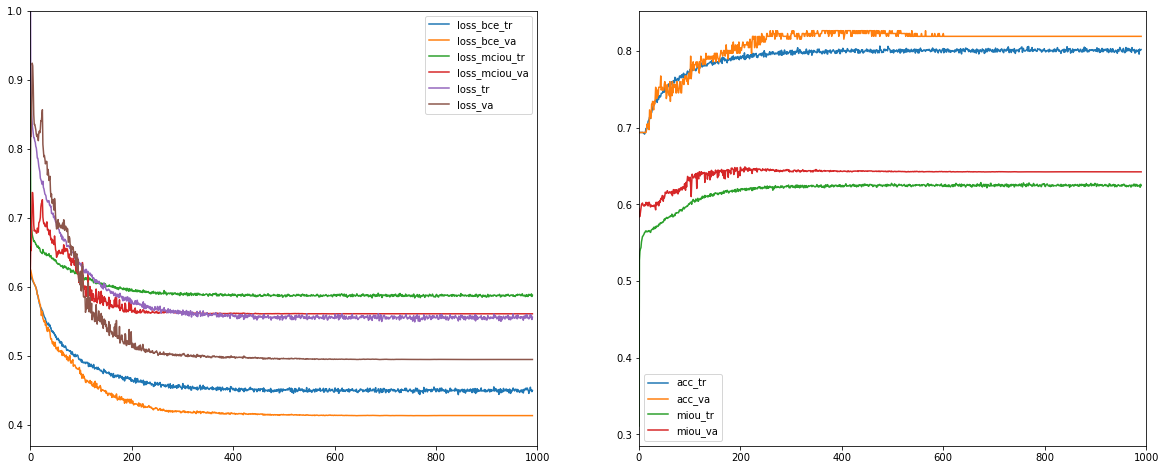

[000] wall:   0:09,  loss: 1.286 / 0.768,  acc.: 0.694 / 0.694,  bce_loss: 0.619 / 0.625,  mciou_loss: 0.927 / 0.612,  miou: 0.311 / 0.595  [000]
[001] wall:   0:09,  loss: 0.881 / 0.829,  acc.: 0.694 / 0.694,  bce_loss: 0.617 / 0.625,  mciou_loss: 0.703 / 0.658,  miou: 0.527 / 0.584  [001]
[002] wall:   0:09,  loss: 0.861 / 0.818,  acc.: 0.694 / 0.694,  bce_loss: 0.615 / 0.621,  mciou_loss: 0.690 / 0.653,  miou: 0.539 / 0.584  [002]
[003] wall:   0:09,  loss: 0.846 / 0.863,  acc.: 0.694 / 0.694,  bce_loss: 0.613 / 0.617,  mciou_loss: 0.682 / 0.690,  miou: 0.542 / 0.589  [003]
[004] wall:   0:09,  loss: 0.835 / 0.924,  acc.: 0.694 / 0.694,  bce_loss: 0.610 / 0.613,  mciou_loss: 0.676 / 0.737,  miou: 0.543 / 0.595  [004]
[005] wall:   0:09,  loss: 0.829 / 0.920,  acc.: 0.694 / 0.694,  bce_loss: 0.609 / 0.611,  mciou_loss: 0.672 / 0.737,  miou: 0.551 / 0.600  [005]
[006] wall:   0:09,  loss: 0.823 / 0.892,  acc.: 0.694 / 0.694,  bce_loss: 0.607 / 0.608,  mciou_loss: 0.670 / 0.719,  miou:

In [17]:
trainer.fit(
    X_tr = images.imgs[images.index_tr],
    X_va = images.imgs[images.index_va],
    y_tr = images.meta_ready[images.index_tr],
    y_va = images.meta_ready[images.index_va],
    batch_size = 50,
    learning_rate = 1e-3,
    optimizer_weight_decay = 1e-4,
    optim_scheduler_step_size = 25,
    optim_scheduler_gamma = 0.75,
    epochs = 1000,
    graph_refreshing_interval = 10,
)

### Testing

In [26]:
trainer.predict(
    X_te = images.imgs[images.index_te],
    y_te = images.meta_ready[images.index_te],
    batch_size = 50,
)

[test] wall: 0.313s,  inference: 0.768ms,  loss: 0.553,  acc.: 0.801,  miou: 0.638  [test]


### Saving the results

In [27]:
trainer.find_best_epoch()

768

In [28]:
trainer.save_state_dicts(6, name='baseline_good_long')

In [29]:
trainer.save_state_dicts(6, only_best_epoch=True)

### Loading the results

In [22]:
# trainer.load_state_dicts(6)

In [23]:
# trainer.find_best_epoch(state_dicts_list=trainer.state_dicts_loaded)

In [30]:
trainer.assign_state_dicts(epoch_from_last_training=768)

{'epoch': 768, 'loss_tr': 0.5502129414864572, 'loss_va': 0.4950937380393346, 'acc_tr': 0.8059844846693757, 'acc_va': 0.8191881918819188, 'loss_bce_tr': 0.4443466533594026, 'loss_bce_va': 0.4137737701336543, 'loss_mciou_tr': 0.5874698810911706, 'loss_mciou_va': 0.5612305303414663, 'miou_tr': 0.6248407363891602, 'miou_va': 0.6424540281295776}


In [31]:
trainer.predict(
    X_te = images.imgs[images.index_te],
    y_te = images.meta_ready[images.index_te],
    batch_size = 50,
)

[test] wall: 0.304s,  inference: 0.747ms,  loss: 0.553,  acc.: 0.801,  miou: 0.638  [test]
